In [10]:
from src.mlds import MLDS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
preamble = r'\usepackage{amsmath}'\
          +r'\usepackage{amssymb}'\
          +r'\usepackage{lmodern}'
mpl.rc('text.latex',preamble=preamble) 

import os

from scipy.spatial.distance import cdist

from joblib import Parallel, delayed
import scipy.stats as st
from scipy.special import i0, i1 


from matplotlib.ticker import FuncFormatter
from matplotlib.legend_handler import HandlerLine2D
def my_formatter(x, pos):
    if x.is_integer():
        return str(int(x))
    else:
    
        return str(x)
formatter = FuncFormatter(my_formatter)

def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(2)

%matplotlib inline

In [11]:
folder = 'data'
    
folder_list = sorted(os.listdir(folder))
n_subjects = 5
n_conds = 15
n_triplets = 81
n_rep = 5
comb_thresh_low = 1
comb_thresh_up = np.inf
resp = np.zeros((n_subjects,n_conds,n_triplets,n_rep))
df = np.zeros((n_subjects,n_conds),dtype=object)
timings = np.zeros((n_subjects,n_conds))
l = 0
for folder_name in folder_list:
    file_name_list = sorted(os.listdir(folder+'/'+folder_name))
    print(folder_name)
    k = 0
    for file_name in file_name_list:
        df[k,l] = pd.read_csv(folder+'/'+folder_name+'/'+file_name)
        resp_raw = np.array(df[k,l]['mlds_resp'])
        resp_raw = resp_raw.reshape(n_rep,n_triplets).T#.shape
        triplet_idx = np.array(df[k,l]['triplet_idx'])
        triplet_idx = triplet_idx.reshape(n_rep,n_triplets).T
        for i in range(n_rep):
            resp[0,l,triplet_idx[:,i],i] += resp_raw[:,i]
        k+=1
    l+=1


exp_ori_bdw
exp_sf
exp_sf_bdw
pair_01
pair_02
pair_03
pair_04
pair_05
pair_06
pair_07
pair_08
pair_09
pair_10
pair_11
pair_12


In [12]:
resp = np.concatenate((resp.mean(0,keepdims=True),
                       0.5*np.ones_like(resp[:1])), axis=0)
n_subjects = 1

In [4]:
# initialize mlds object 
n_step, comb_thresh_low, comb_thresh_up, n_iter, seed =  13, 1, 3, 10000, 0
comb_max_delta = 3

def bootstrap_it(resp, n_subjects, n_conds):
    f_bt = np.zeros((1,n_subjects+1,n_conds,n_step))
    σ_bt = np.zeros((1,n_subjects+1,n_conds))

    mlds = MLDS(n_step, comb_thresh_low=comb_thresh_low,
                    comb_thresh_up=comb_thresh_up,
                    comb_max_delta=comb_max_delta,
                    n_iter=n_iter, seed=seed)
    
    for k in range(n_subjects+1):
        for l in range(n_conds):
            resp_ = np.zeros((n_triplets,n_rep))
            for i in range(n_rep):
                resp_[:,i] = st.bernoulli(resp.mean(3)[k,l]).rvs()

            f_bt[0,k,l], σ_bt[0,k,l] = mlds.fit(resp_, prior=False)
        
    return f_bt, σ_bt

n_jobs = 10
parallel =  Parallel(n_jobs=n_jobs, verbose=5)

In [5]:
mlds = MLDS(n_step, comb_thresh_low=comb_thresh_low,
                    comb_thresh_up=comb_thresh_up,
                    comb_max_delta=comb_max_delta,
                    n_iter=n_iter, seed=seed)
        
N = 1000;
f_bt = np.zeros((N,n_subjects+1,n_conds,n_step))
σ_bt = np.zeros((N,n_subjects+1,n_conds))

f = np.zeros((n_subjects+1,n_conds,n_step))
σ = np.zeros((n_subjects+1,n_conds))

for k in range(n_subjects+1):
    for l in range(n_conds):
        f[k,l], σ[k,l] = mlds.fit(resp[k,l], prior=False)

joblist = [delayed(bootstrap_it)(resp,n_subjects,n_conds) for i in range(N)];
retlist  =  parallel(joblist);

f_bt = np.concatenate([retlist[i][0] for i in range(N)],0)
σ_bt = np.concatenate([retlist[i][1] for i in range(N)],0)

f_ci = f+np.quantile(f_bt-f,[0.005,0.995], axis=0)

# removing numerical errors
σ_bt[:,-1][σ_bt[:,-1]<0] = 1e-1\
        +3*np.random.rand(np.sum(σ_bt[:,-1]<0))
σ_bt[:,-1][σ_bt[:,-1]>1e8] = 1e-1\
        +3*np.random.rand(np.sum(σ_bt[:,-1]>1e8))

# noise observer
σ[-1] = σ_bt[:,-1].mean()
f[-1] = f_bt[:,-1].mean(0)
σ_ci = σ+np.quantile(σ_bt-σ,[0.005,0.995], axis=0)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    5.7s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   13.2s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:   23.9s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   38.4s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   56.7s
[Parallel(n_jobs=10)]: Done 862 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 1000 out of 1000 | elapsed:  1.5min finished


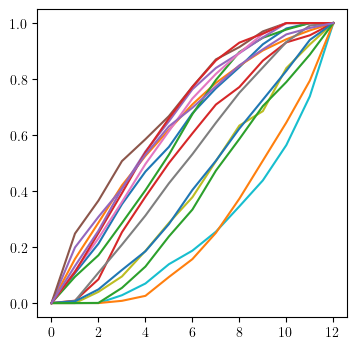

In [6]:
fig, ax = plt.subplots(1,1,figsize=(4.0,4.0))
ax.plot(f[0].T);

In [7]:
def plot_mlds_res(f, f_ci, f_th=0, color='gray',
                  label=[''], label_xy=['',''],
                  legend=False, figsize=(2.5,2.5)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    x = np.linspace(0,1,f.shape[0])
    tex = []
    tex += [ax.errorbar(x, f, np.abs(f-f_ci), ls='', marker='o', color=color,
                      capsize=5, label=r'human')[0],]
    ax.set_title(label, fontsize=18)
    if np.isscalar(f_th)==False:
        x_th = np.linspace(0,1,f_th.shape[0])
        tex += ax.plot(x_th,f_th, c=color, label=r'theory')
        
    ax.tick_params('both', labelsize=18)
    ax.set_xlim(0,1)
    ax.set_ylim(-0.01,1.01)
    ax.plot([0,1],[0,1], c='k')
    if legend:
        ax.legend(tex, [r'human', r'theory'], fontsize=16,
                handler_map={plt.Line2D : HandlerLine2D(update_func=update)},
                handlelength=0.75,handleheight=0.0, handletextpad=0.5,
                borderaxespad=0.2, edgecolor='k',
                frameon=True, borderpad=0.4, labelspacing=0.2,
                columnspacing=0.5, bbox_to_anchor=(0.39,0.02),
                loc='lower left',ncol=1)
    if not legend:
        ax.set_yticklabels([])

    ax.set_ylabel(label_xy[0], fontsize=20, labelpad=5);
    ax.set_xlabel(label_xy[1], fontsize=20)
    
    return fig, ax

In [8]:
# prediction

f_th = np.zeros((3+12,100))
f_th_ps = np.zeros((3+12,100))
f_th_px = np.zeros((3+12,100))
f_th_wave = np.zeros((3+12,100))

# sf
EPS = 1e-3
x = np.linspace(EPS,1-EPS, 100)
z0 = 256./38.*(0.5+3.0*x)
f_th[1] = np.log(z0/z0[0])/np.log(z0[-1]/z0[0])

# sf bdw
bz = 0.25+3.0*x
phi_bz = np.sqrt(np.log(2)/2*(1+4/(bz**2*np.log(2))))
f_th[2] = np.cumsum(phi_bz)/phi_bz.sum()

# ori bdw
sig_bdw = (1.5+12*x)*np.pi/180.0#0.025+0.3*x
phi_ori_bdw = np.sqrt( 1/(4*sig_bdw**6)\
                *(1 - i1(1/(4*sig_bdw**2))/i0(1/(4*sig_bdw**2))\
                    *(4*sig_bdw**2+i1(1/(4*sig_bdw**2))/i0(1/(4*sig_bdw**2)))))
f_th[0] = np.cumsum(phi_ori_bdw)/phi_ori_bdw.sum()


pred_mlds = np.load('pred_mlds.npz')['pred_mlds']

f_th_px[3:] = pred_mlds[:,0].cumsum(1)
f_th_ps[3:] = pred_mlds[:,1].cumsum(1)
f_th_wave[3:] = pred_mlds[:,2].cumsum(1)
f_th[3:] = pred_mlds[:,3:].mean(1).cumsum(1)

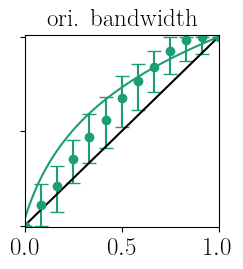

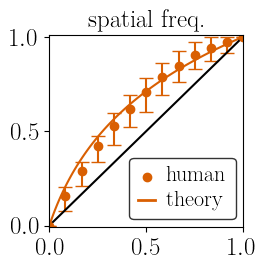

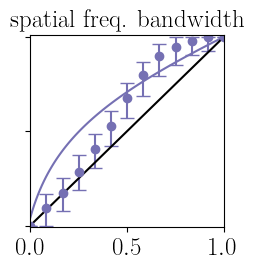

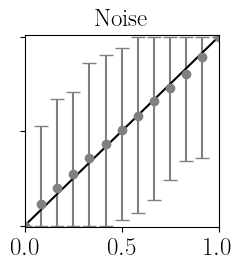

In [9]:
colors = ['#1b9e77','#d95f02','#7570b3','gray']
#colors = ['#377eb8','#377eb8','#377eb8','gray']
labels = ['ori. bandwidth', 'spatial freq.','spatial freq. bandwidth','Noise']
save_names = ['ori_bdw', 'sf', 'sf_bdw']
label_xy = [[r'perceptual scale ($f$)',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)']]
label_xy = [[r'',r''],
            [r'',r''],
            [r'',r'']]

indexes = [0,1,2]
n_conds= 3
        
for i in range(n_conds):
    if i == 1:
        legend = True
    else:
        legend = False
    fig, ax = plot_mlds_res(
                f[0,indexes[i]], f_ci[:,0,indexes[i]], f_th=f_th[i],
                color=colors[i], label=labels[i], label_xy=label_xy[i],
                legend=legend)
    
    fig.savefig('figs/mlds_pop_'+save_names[i]+'.pdf',
                 format='pdf', bbox_inches='tight')

    #if i>0:
    #    plt.close()
    
fig, ax = plot_mlds_res(f[-1,indexes[-1]], f_ci[:,-1,indexes[-1]],
                   color=colors[-1], label=labels[-1],label_xy=label_xy[-1])
#plt.close()

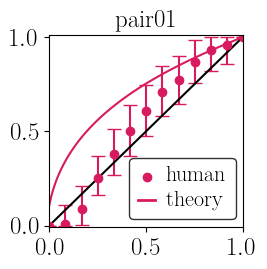

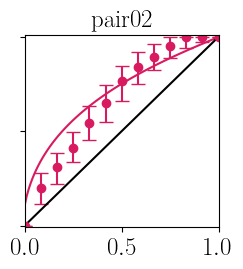

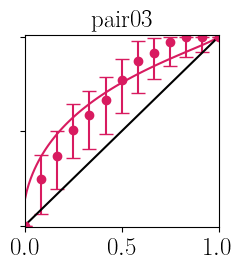

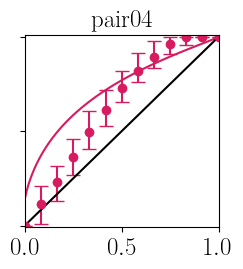

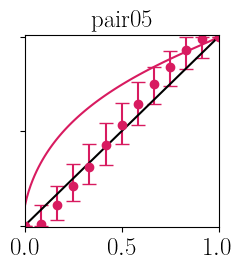

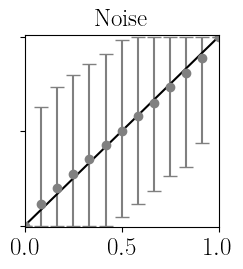

In [13]:
#colors = plt.cm.Accent([1,2,4,5,6,7])
#colors = np.append(colors, [[0.5,0.5,0.5,1]], axis=0)
colors = ['#D81B60','#D81B60','#D81B60','#D81B60','#D81B60','gray']
labels = ['pair{:0>2}'.format(1+i) for i in range(5)]+['Noise']
label_xy = [[r'perceptual scale ($f$)',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)']]
label_xy = [[r'',r''],
            [r'',r''],
            [r'',r''],
            [r'',r''],
            [r'',r'']]

indexes = [3,4,5,6,7]
n_conds= 5
        
for i in range(n_conds):
    if i == 0:
        legend = True
    else:
        legend = False
    
    fig, ax = plot_mlds_res(f[0,indexes[i]], f_ci[:,0,indexes[i]],
                   f_th=f_th_ps[indexes[i]],
                   color=colors[i], label=labels[i],label_xy=label_xy[i],
                   legend=legend)
    fig.savefig('figs/mlds_pop_'+labels[i]+'.pdf',
                format='pdf', bbox_inches='tight')

    #plt.close()
    
fig, ax = plot_mlds_res(f[-1,indexes[-1]], f_ci[:,-1,indexes[-1]],
                   color=colors[-1], label=labels[-1],label_xy=label_xy[-1])
#plt.close()

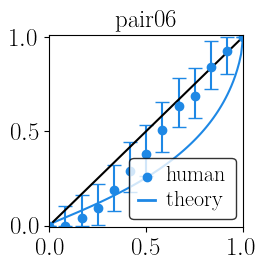

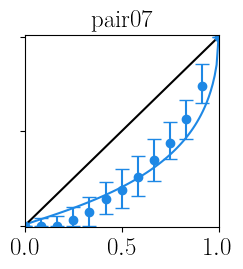

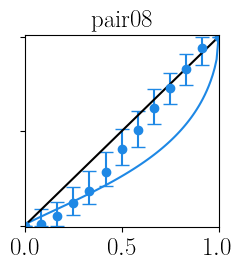

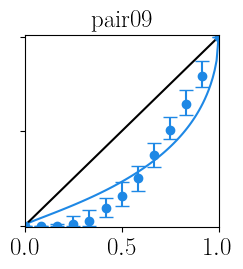

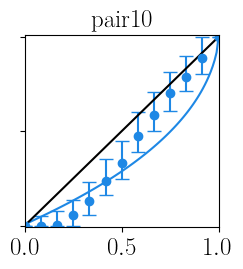

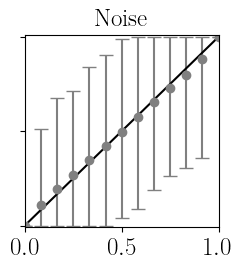

In [14]:
colors = plt.cm.Set2([1,2,3,4,6])
colors = np.append(colors, [[0.5,0.5,0.5,1]], axis=0)
colors = ['#1E88E5','#1E88E5','#1E88E5','#1E88E5','#1E88E5','gray']
labels = ['pair{:0>2}'.format(6+i) for i in range(5)]+['Noise']
label_xy = [[r'perceptual scale ($f$)',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)']]
label_xy = [[r'',r''],
            [r'',r''],
            [r'',r''],
            [r'',r''],
            [r'',r'']]

indexes = [8,9,10,11,12]
n_conds= 5
        
for i in range(n_conds):
    if i == 0:
        legend = True
    else:
        legend = False

    fig, ax = plot_mlds_res(f[0,indexes[i]], f_ci[:,0,indexes[i]],
                   f_th=f_th_ps[indexes[i]],
                   color=colors[i], label=labels[i],label_xy=label_xy[i],
                   legend=legend)
    fig.savefig('figs/mlds_pop_'+labels[i]+'.pdf',
            format='pdf', bbox_inches='tight')
    
fig, ax = plot_mlds_res(f[-1,indexes[-1]], f_ci[:,-1,indexes[-1]],
                   color=colors[-1], label=labels[-1],label_xy=label_xy[-1])

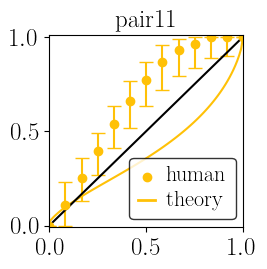

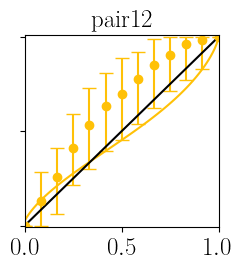

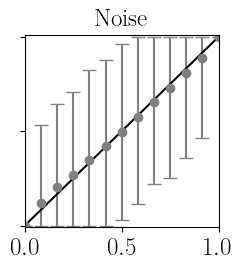

In [15]:
colors = plt.cm.Set1_r([5,6])
colors = np.append(colors, [[0.5,0.5,0.5,1]], axis=0)
colors = ['#FFC107','#FFC107','#FFC107','#FFC107','#FFC107','gray']
labels = ['pair{:0>2}'.format(11+i) for i in range(2)]+['Noise']
label_xy = [[r'perceptual scale ($f$)',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)'],
            [r'',r'interpolation weight ($s$)']]
label_xy = [[r'',r''],
            [r'',r''],
            [r'',r''],
            [r'',r''],
            [r'',r'']]

indexes = [13,14]
n_conds= 2
        
for i in range(n_conds):
    if i == 0:
        legend = True
    else:
        legend = False

    fig, ax = plot_mlds_res(f[0,indexes[i]], f_ci[:,0,indexes[i]], 
                   f_th=f_th_ps[indexes[i]],
                   color=colors[i], label=labels[i],label_xy=label_xy[i],
                   legend=legend)

    fig.savefig('figs/mlds_pop_'+labels[i]+'.pdf',
            format='pdf', bbox_inches='tight')

    
fig, ax = plot_mlds_res(f[-1,indexes[-1]], f_ci[:,-1,indexes[-1]],
                   color=colors[-1], label=labels[-1],label_xy=label_xy[-1])
fig.savefig('figs/mlds_pop_'+labels[-1]+'.pdf',
        format='pdf', bbox_inches='tight')

In [17]:
x_ = np.linspace(0,1,f.shape[-1])
dist_mat = cdist(x_[np.newaxis].T,x[np.newaxis].T)
idx_min = dist_mat.argmin(1)

In [18]:
def score_mlds(f_th,f):
    x = np.linspace(0,1,f.shape[-1])
    fmx = f-x
    sign_fmx = np.sign(fmx)
    f_thmx = f_th-x
    return np.sum(sign_fmx*f_thmx)/np.sum(np.abs(fmx))

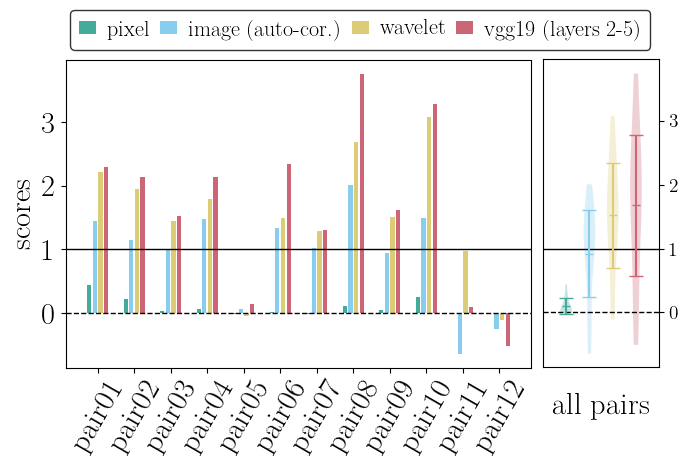

In [28]:
figsize = (6,4)
fig, ax = plt.subplots(1,1,figsize=figsize)
ax.axhline(0, c='k', ls='--', lw=1)
ax.axhline(1, c='k', ls='-', lw=1)
colors = ['#44AA99', '#88CCEE', '#DDCC77',
          '#CC6677', '#999999']
labels = ['pixel', 'image (auto-cor.)', 'wavelet', 'vgg19 (layers 2-5)']
indexes = [3,4,5,6,7,8,9,10,11,12,13,14]
n_conds = 12
score_mlds_comp = np.zeros((4,n_conds))


fact = 1.3
x_offset = 1+np.array([-0.3,-0.1,0.1,0.3])
x_pos = np.arange(1,n_conds+1)
for i in range(n_conds):
    score_mlds_comp[0,i] = score_mlds(
                            f_th_px[indexes[i],idx_min],f[0,indexes[i]])
    score_mlds_comp[1,i] = score_mlds(
                            f_th_ps[indexes[i],idx_min],f[0,indexes[i]])
    score_mlds_comp[2,i] = score_mlds(
                            f_th_wave[indexes[i],idx_min],f[0,indexes[i]])
    score_mlds_comp[3,i] = score_mlds(
                            f_th[indexes[i],idx_min],f[0,indexes[i]])
    
for i in range(4):
    ax.bar(fact*x_pos+x_offset[i],score_mlds_comp[i], 
           width=0.15, color=colors[i], label = labels[i])

pos = ax.get_position()
ax0 = fig.add_axes([0.92, pos.x0-0.013, 1.0*pos.width/4, pos.height])
ax0.yaxis.tick_right()
ax0.yaxis.set_label_position('right')
ax0.set_xticks([]);

ax0.axhline(0, c='k', ls='--', lw=1)
ax0.axhline(1, c='k', ls='-', lw=1)

n_sig = 3

for i in range(4):
    parts = ax0.violinplot(score_mlds_comp[i], positions=np.array([i]),
                           showmeans=False, showextrema=False)
    ax0.errorbar(np.array([i]),score_mlds_comp[i].mean(),
                 yerr=n_sig*score_mlds_comp[i].std()/np.sqrt(n_conds-1),
                 fmt='_', color=colors[i], capsize=5)
    for pc in parts['bodies']:
        pc.set_facecolor(colors[i])

ax.set_xticks(1+fact*x_pos);
ax.set_xticklabels(['pair{:0>2}'.format(1+i) for i in range(12)],
                    rotation=60);
ax.tick_params(labelsize=22)
ax.set_ylabel('scores', fontsize=22)
ax.legend(fontsize=16,
          handler_map={plt.Line2D : HandlerLine2D(update_func=update)},
          handlelength=0.75,handleheight=0.5, handletextpad=0.5,
          borderaxespad=0.2, edgecolor='k',
          frameon=True, borderpad=0.4, labelspacing=0.2,
          columnspacing=0.5, bbox_to_anchor=(-0.0,1.02),
          loc='lower left',ncol=4)

ax0.tick_params(labelsize=14)
ax0.set_xlabel('all pairs', fontsize=22, labelpad=15)
ax0.set_xlim(-1.0,4.0)

fig.savefig('figs/mlds_score_model_comp.pdf',
            format='pdf', bbox_inches='tight')
